IZENA: Oier

ABIZENAK: Alvarez

# Eguzki sistemaren 5 gorputzeko eredua

Eguzki sistemaren 5 gorputzeko sistema batekin egingo dugu lan. Bertan, bost masa puntual Newton-en grabitate legearen arabera mugituko dira: Eguzkia, Jupiter, Saturno, Urano, eta Neptuno.

<ul id="top">

<a href="#top">Ir al inicio</a>

## Paketeak eta funtzioak kargatu

In [377]:
#= import Pkg
Pkg.add("LinearAlgebra")
Pkg.add("OrdinaryDiffEq")
Pkg.add("Polynomials") =#
using LinearAlgebra
using Plots
using OrdinaryDiffEq
using Polynomials

In [378]:
include("KanpokoEguzkiSistema.jl")

NbodyODE2! (generic function with 1 method)



## 1 - $N$ gorputzeko eredua matematikoaren definizioa


Sistemaren energia, $q_1,\ldots,q_N \in \mathbb{R}^3$  kokapenen eta  $v_1,\ldots,v_N \in \mathbb{R}^3$  abiadura bektoreen funtzio gisa honakoa da:
\begin{equation*}
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
\end{equation*}


Ekuazio diferentzialen sistema:
\begin{equation}
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split} \tag{1}
\end{equation}

Sistema hori modu trinkoan horrela adieraziko dugu:

\begin{equation*}
\frac{d u}{dt} = f(t,u,p). \tag{2}
\end{equation*}



Egoera aldagaiak, bektore batean bildu beharrean, hiru indizeko array batean horrela gordeko ditugu:

\begin{equation*}
u = 
\left(\begin{matrix}
q_1  & v_1\\
\vdots & \vdots \\
q_N  & v_N
\end{matrix}
\right) \in \mathbb{R}^{3\times N \times 2}.
\end{equation*}

Aldiz, parametro konstanteen bektorea honakoa da:

\begin{equation*}
p = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
\end{equation*}

**Unitate neurriak:** distantzia unitate astronomikotan (AU), eta denbora egunetan.

### 1.1 NbodyEnergy(u,p) funtzioa inplementatu, sistemaren energia bider $G$ kalkulatzen duena

In [379]:
function NbodyEnergy(u,p)
   N = length(p)
   T = 0.
   U = 0.
   for i in 1:N
      qi = u[:,i,1]
      vi = u[:,i,2]
      Gmi = p[i]
      T += Gmi*dot(vi,vi)
      for j in (i+1):N
         qj = u[:,j,1]
         Gmj = p[j]
         qij = qi - qj
         U -= (Gmi * Gmj)/sqrt(dot(qij,qij)^3)
      end
   end
  return T + U
end

NbodyEnergy (generic function with 1 method)

### 1.2 $N$ gorputzeko problema (2) formatuan jartzeko behar den NbodyODE!(du,u,p,t) funtzioa inplementatu. 

In [380]:
function NbodyODE!(du,u,p,t)
    # Hemen, du taulan jarriko dira $f(t,u,p)$ aplikazioaren osagaiak. 
    N = length(p)
    du[:,:,2] .= 0
    for i in 1:N
       xi = u[1,i,1]
       yi = u[2,i,1]
       zi = u[3,i,1]
       Gmi = p[i] 
       for j in (i+1):N
          xij = xi - u[1,j,1]
          yij = yi - u[2,j,1]
          zij = zi - u[3,j,1]
          Gmj = p[j] 
          dotij = xij^2+yij^2+zij^2
          auxij = 1 / sqrt(dotij^3)
          du[1,i,2] -= Gmj*auxij*xij
          du[1,j,2] += Gmi*auxij*xij
          du[2,i,2] -= Gmj*auxij*yij
          du[2,j,2] += Gmi*auxij*yij
          du[3,i,2] -= Gmj*auxij*zij
          du[3,j,2] += Gmi*auxij*zij
       end
    end
   du[:,:,1] .= u[:,:,2] 
   return nothing
end




NbodyODE! (generic function with 1 method)

##### <a href="#top">Hasierara</a>

## 2 - Eguzki sistemaren bilakaeraren datu "errealak"

KanpokoEguzkiSistemarenDatuak(tend) funtzioak kanpoko eguzki-sistemaren datu "errealak" itzultzen dizkigu $[0,t_{end}]$ denbora-tartearen diskretizazio uniforme jakin baterako. Hemen, $t_{end}=60182$ da, Neptunoren periodoa egunetan.

Datu horiek lortzeko, 16 gorputzeko eredu errealistago baten simulazioa egin da: eguzkia, eguzki-sistemako zortzi planetak, ilargia, Pluto, eta Ceres, Pallas, Vesta, Iris eta Bamberga (Marte eta Jupiterren arteko asteroide gerrikoko bost objektu handienak). Hasierako datuak 1969ko ekainaren 28koak dira (Julian Day (TDB) 2440400.5), DE430 efemerideetatik lortutakoak.

In [381]:
tend= 60182. # Neptunoren gutxi gorabeherako periodoa egunetan
datos_t, datos_u = KanpokoEguzkiSistemarenDatuak(tend);

### 2.1 - Hiru irudi lortu, OXY, OXZ eta OYZ planoetako proiekzioei dagozkienak, hurrenez hurren, kanpoko lau planeten orbiten grafikoekin.


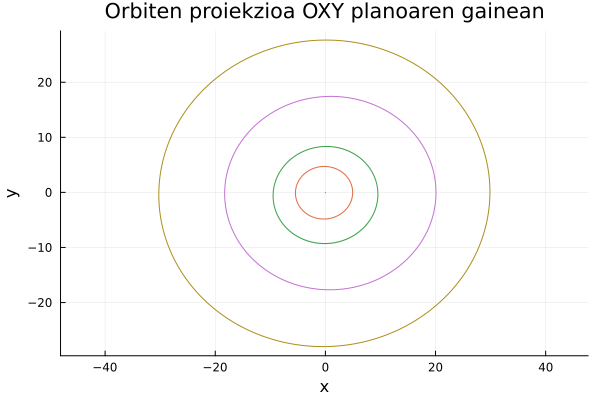

In [382]:
pl = plot(title="Orbiten proiekzioa OXY planoaren gainean", 
            xlabel="x", ylabel="y", legend=false, aspect_ratio=1)

  for j = 1:5
    x  = [u[3j-2] for u in datos_u]
    y  = [u[3j-1] for u in datos_u] 
    pl = plot!(x,y) 
  end 
display(pl)

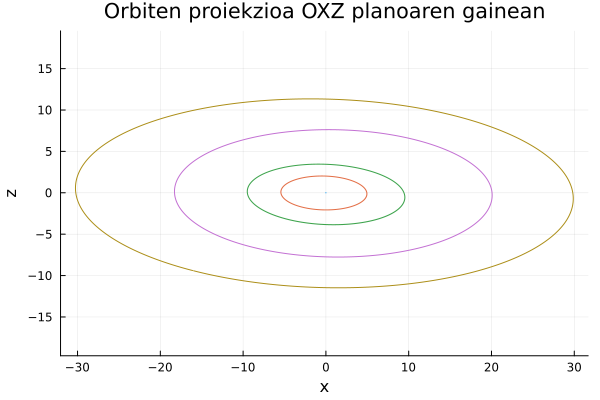

In [383]:
pl = plot(title="Orbiten proiekzioa OXZ planoaren gainean", 
            xlabel="x", ylabel="z", legend=false, aspect_ratio=1)

  for j = 1:5
    x  = [u[3j-2] for u in datos_u]
    z  = [u[3j] for u in datos_u] 
    pl = plot!(x,z) 
  end 
display(pl)

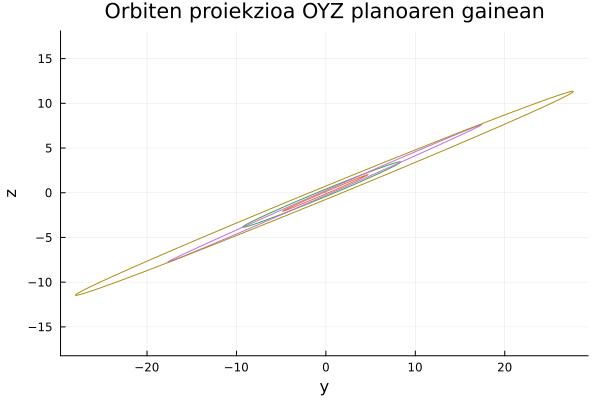

In [384]:
pl = plot(title="Orbiten proiekzioa OYZ planoaren gainean", 
            xlabel="y", ylabel="z", legend=false, aspect_ratio=1)

  for j = 1:5
    y  = [u[3j-1] for u in datos_u]
    z  = [u[3j] for u in datos_u] 
    pl = plot!(y,z) 
  end 
display(pl)

##### <a href="#top">Hasierara</a>

## 3 - Kanpoko eguzki sistemaren eredu matematikoaren soluzioa

KanpokoEguzkiSistemarenHasierakoDatuak() honakoa itzultzen digu:

- Sistemaren hasierako $u_0$ egoera 1969ko ekainaren 28an (Julian Day (TDB) 2440400.5), DE430 efemerideetatik lortuak), 
- Parametro konstanteen osagaien $p_i = G\, m_i$  ($i=1,2,3,4,5$) balioak, eta 
- Gorputz bakoitzaren izenen zerrenda. 

In [385]:
u0, p, bodylist = KanpokoEguzkiSistemarenHasierakoDatuak()
GmNeptuno = p[5]
N = length(p)
bodylist

1×5 Matrix{String}:
 "Barneko Eguzki Sistema"  "Jupiter"  "Saturno"  "Urano"  "Neptuno"

Neptunori dagokion $G\, m_5 $-ren balioa 1992an balio hori zuzendu aurretik zegoena da.
(1989an Neptunoren orbitatik gertu Voyager2 pasa zenean jasotako datuekin zuzendu zen Neptunoren masa.)

### 3.1 - Bost gorputzen problemaren emaitzak lortu  datos_t taulan emandako $t_1,\ldots, t_m $ denboretarako, horretarako Vern9() metodoa aplikatuz  $h = 300$ urrats luzerarekin

In [386]:
tspan = (0.,datos_t[end])
prob = ODEProblem(NbodyODE!, u0, tspan, p)
h = 300.
tt = similar(datos_t)
#sol = solve(prob, Vern9(), adaptive=false, dt=h, saveat=tt)

sol = solve(prob, Vern9(), abstol = 1e-14, reltol= 1e-14, saveat=h )

tt = sol.t[2:end-1]

uu = sol.u[2:end-1]


200-element Vector{Array{Float64, 3}}:
 [0.0040498084276147156 -4.624687846002632 … -18.159414436672744 -15.254653876035388; 0.002238919950336125 -2.6653589884931534 … -2.2873607462082397 -24.380162057551257; 0.000907658128472971 -1.0298022188037599 … -0.7445100889458545 -9.599341857416952;;; -2.7019372410838535e-6 0.0038751592142110213 … 0.0004850329840972503 0.002692687764422279; 4.459768041741166e-6 -0.005544944566853134 … -0.003737526393278765 -0.0014212546918226795; 1.9729381859763475e-6 -0.0024714487430793726 … -0.00164382429844015 -0.0006487439423437584]
 [0.002936216402766517 -3.113958104112006 … -17.9746663433366 -14.439679517565443; 0.003353194572023675 -4.063560113523807 … -3.4028610531527765 -24.7948064908193; 0.0014099745830040628 -1.66600391397917 … -1.235691365598627 -9.789341465147897;;; -4.60391929706489e-6 0.006065836414065965 … 0.0007460414227743957 0.002740043941045533; 2.8413707957023975e-6 -0.0036364934334342488 … -0.0036964787802940447 -0.001342818064226802; 1.31

### 3.2 - Energiaren errore erlatiboaren bilakaera irudikatu eskala logaritmikoan


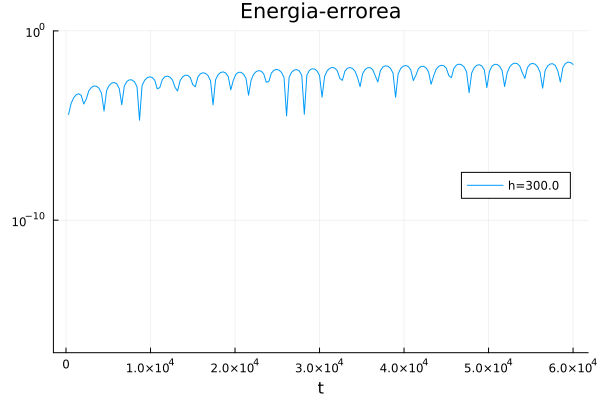

In [387]:
ee = [NbodyEnergy(u,p) for u in uu]
EE = [NbodyEnergy(datos_u[i], p) for i = 1:length(datos_u) if i % 10 == 0 ]
err = abs.((ee .- EE) ./ EE)
pl = plot(tt, err, xlabel="t", title="Energia-errorea", 
                     yscale=:log10, ylims=(1e-17,1),
                     label="h=$h", legend=:right )

### 3.3 -  Kalkuluak errepikatu $h = 150$ urrats-luzerarekin, eta gehitu aurreko irudiari emaitza berrien energia-errore erlatiboaren bilakaeraren grafikoa. Gehitu, halaber, energia-errore-erlatiboaren grafikoa $h = 75$ urrats-luzeraren kasuan


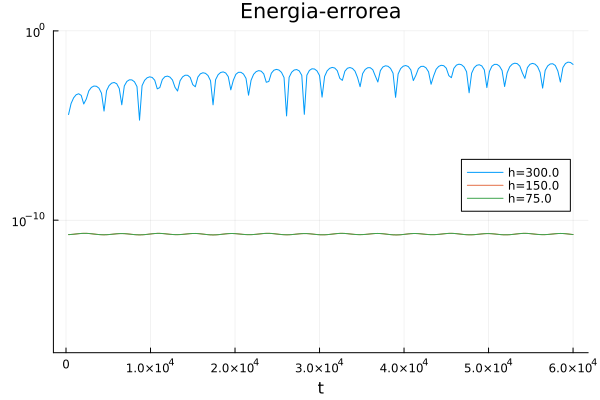

In [388]:
    h /= 2
    sol2 = solve(prob, Vern9(), adaptive=false, dt=h, saveat=tt )
    EE = [NbodyEnergy(u,p) for u in sol2.u]
    plot!(sol2.t, EE, label="h=$h", legend=:right )

    h /= 2
    sol2 = solve(prob, Vern9(), adaptive=false, dt=h, saveat=tt )
    EE = [NbodyEnergy(u,p) for u in sol2.u]
    plot!(sol2.t, EE, label="h=$h", legend=:right )


### 3.4 Alde batetik datu errealak  eta bestetik zenbakizko integrazioarekin lortutako emaitzak hartuz irudi bakar batean irudikatu planeta bakoitzaren kokapenen diferentzien normaren bilakaera (eskala logaritmikoan)


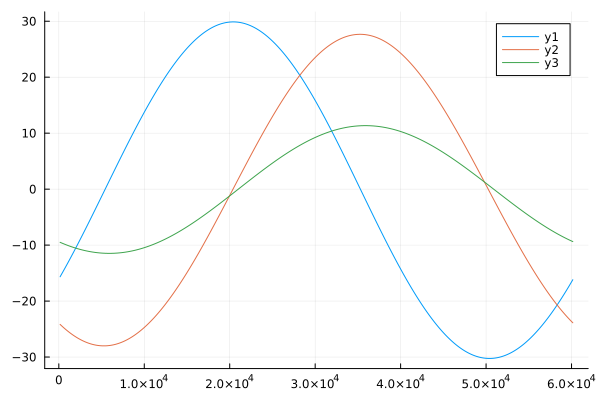

In [389]:
h = 150.
sol = solve(prob, Vern9(), abstol = 1e-14, reltol= 1e-14, saveat=h )
tt = sol.t[2:end-1]
uu = sol.u[2:end-1]
X = zeros(length(uu))
Y = zeros(length(uu))
Z = zeros(length(uu))
for j in 1:5
    X = [u[3j-2] for u in uu]
    Y = [u[3j-1] for u in uu]
    Z = [u[3j] for u in uu]
end    
plot(tt, X)
plot!(tt, Y)
plot!(tt, Z)

### 3.5 Vern9 metodoarekin eta $h=150$ urrats luzerarekin kalkulatutako emaitzen posizioetako zenbakizko erroreak estimatu (bigarren gaiko amaierako teknika erabiliz), eta 3.4 ataleko irudi berean gehitu errore horien normaren bilakaeraren grafikoak (eskala logaritmikoan).


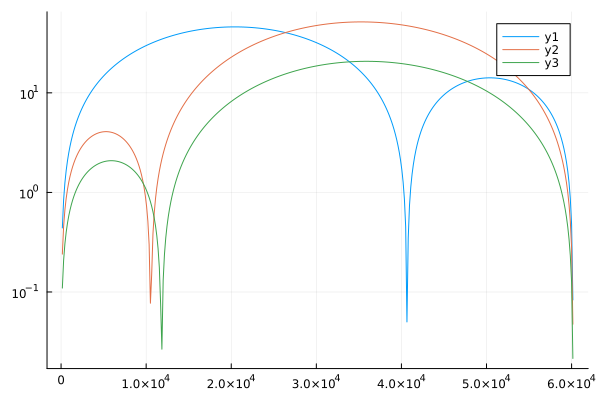

In [390]:
h = 150.
sol = solve(prob, Vern9(), abstol = 1e-14, reltol= 1e-14, saveat=h )
tt = sol.t[2:end-1]
uu = sol.u[2:end-1]
x = zeros(length(uu))
X = zeros(length(uu))
y = zeros(length(uu))
Y = zeros(length(uu))
z = zeros(length(uu))
Z = zeros(length(uu))
err_xx = zeros(length(uu))
err_yy = zeros(length(uu))
err_zz = zeros(length(uu))
for j in 1:5
    X = [u[3j-2] for u in uu]
    Y = [u[3j-1] for u in uu]
    Z = [u[3j] for u in uu]
    for u in datos_u
        x = [u[3j-2] for _ in 1:length(uu)]
        y = [u[3j-1] for _ in 1:length(uu)]
        z = [u[3j] for _ in 1:length(uu)]
    end
    err_xx = abs.(X .- x)
    err_yy = abs.(Y .- y)
    err_zz = abs.(Z .- z)
end    
plot(tt, err_xx, yscale=:log10)
plot!(tt, err_yy, yscale=:log10)
plot!(tt, err_zz, yscale=:log10)

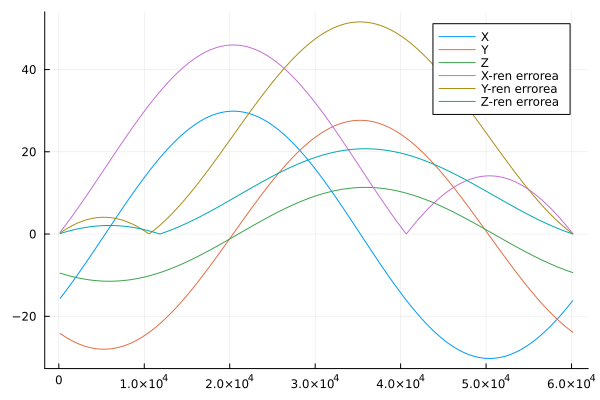

In [391]:
plot(tt, X, label = "X")
plot!(tt, Y, label = "Y")
plot!(tt, Z, label = "Z")
plot!(tt, err_xx, label = "X-ren errorea")
plot!(tt, err_yy, label = "Y-ren errorea")
plot!(tt, err_zz, label = "Z-ren errorea")

### 3.6 Vern9 metodoarekin eta $h=150$ urrats luzerarekin kalkulatutako emaitzen posizioetako zenbakizko errore estimatuen tamainia ikusirik, 3.4 atalean lortutako grafikoa fidagarria dela esango zenuke?


>Jasotako erroreak oso handiak ez direnez, aurreko grafiko hori nahiko fidagarria dela esango nuke.
> Erantzuna hemen idatzi

##### <a href="#top">Ir al inicio</a>

## 4 - Neptunoren masaren doikuntza

Atal honetan, $p_5 = G\, m_5$ parametroa doitzen saiatuko gara, parametroaren balio horretarako lortutako emaitza simulatuak, gutxieneko karratuen zentzuan, datu errealekin (ahal den neurrian)  bat etor daitezen.


### 4.1 - Errfcn (x) funtzio bat definitu, parametroaren  $x = G\, m_5$ balioari dagokion hondarra. Hau da, lau planeten posizioen osagai bakoitzaren diferentzien karratuen batura, datu errealen eta (Vern9 metodoarekin $h=150$ urrats luzera erabiliz) kalkulatuta emaitzen arteko desadostasunaren neurri gisa 

In [392]:
p_= copy(p)
N = length(p)
prob_ = ODEProblem(NbodyODE!, u0, tspan, p_)

function errfcn(x)
    p_[5] = x
    h = 300.
    ...
    return norm2err
end

ErrorException: syntax: invalid identifier name "..."

### 4.2 errfcn(x) funtzioaren grafikoa irudikatu,  $[0.9 G m_5, 1.1 G m_5]$ tartean uniformeki banatutako $x$-en 11 baliotarako

In [393]:
xa = 0.9*p[5]
xb = 1.1*p[5]
xrange = ?
errores = ?

scatter(xrange, errores, legend=false)

ErrorException: syntax: invalid identifier name "?"

### 4.3 -  Lortu $x$-ren balio horien artean $x = x_ {min}$ balioa, errfcn (x) hondarraren baliorik txikiena hartzen duena, eta alderatu balio hori $x = G\, m_5$-rekin lortzen zenarekin.

In [394]:
...
xmin = ?

(errfcn(p[5]), errfcn(xmin))

ErrorException: syntax: invalid identifier name "..."

### 4.4 - Errepikatu orain 3.4 ataleko grafikoa, baina $G\, m_5$ erabili beharrean, $p_5=x_ {min}$ hartuta

In [395]:
...

ErrorException: syntax: invalid identifier name "..."

In [396]:
...

ErrorException: syntax: invalid identifier name "..."

Oraingoan, 3.4 ataleko diferentzien aldean, diferentzia txikiagoak lortu beharko lirateke. Alegia, masaren balio berriarekin, emaitza simulatuak datu errealetara hobe doitzen dira.

## 5 - Neptunoren masaren doikuntza zehatzagoa

Hemen, $G\, m_5 $-ren balioaren doikuntza zehatzagoa egiteko,

- Errfcn(x) funtzioa $x = x_\min $-ren inguruan hurbilduko dugu 2. mailako $P_2 (x)$ polinomio baten bidez, errfcn(x) funtzioarekin bat datorrena $x$ aldagaiaren ondoko hiru balioetan: $x_\min$, eta $x_\min$-en gertuen dituen xrange-ko bi $x$-en balioak.

- Errfcn(x) minimizatzen duen $x$-ren balioa honela hurbilduko dugu: $P '_2 (x) = 0$ ekuazioa askatuko dugu. Horrela lortutako $x$-ren balio horrek $P_2(x)$ minimizatzen duela egiaztatuko dugu, eta beraz, errfcn(x) gutxi gorabehera minimizatzen duela.

### 5.2 - Polynomials paketeko fit funtzioa erabiliz, kalkulatu $P_2 (x)$ polinomio interpolatzailea. Eskatutako hiru interpolazio-baldintzak betetzen dituela egiaztatu.

In [397]:
...

ErrorException: syntax: invalid identifier name "..."

### 5.3 - Kalkulatu $x=x_\min^*$ non $P_2'(x)=0$ den
_Oharra_: Polynomials paketearekin lortutako P2 polinomioaren koefizienteen bektorea P2.coeffs modual lor daiteke.

In [398]:
xmin_ = ?

ErrorException: syntax: invalid identifier name "?"

### 5.4 - Konparatu $x = x_\min^*$ berri honen errfcn(x) balioa (4.3 atalean lortutako) errfcn($x_\min$) balioarekin


In [399]:
(errfcn(xmin_)), errfcn(xmin)

UndefVarError: UndefVarError: errfcn not defined

Oharra: 5.3 atalean lortutako $x =x_\min^*$  balio optimorako errfcn(x) balioa errfcn($x_\min$) baino zertxobait txikiagoa izan beharko litzateke.

### 5.5 Errepikatu orain 3.4 eta 4.4 ataletako grafikoak, baina oraingoan $p_5 = x_\min^*$-ren balio berriari dagokion simulazioarekin

In [400]:
...

ErrorException: syntax: invalid identifier name "..."

### 5.6 Datu errealetara hobeto egokitzen al da eredu matematikoaren soluzioa $p_5= x_\min^*$ balioarekin?